# Relaxation time Calculations

Goal of this notebook is to calculate and save the typical subjects  and the significant RoIs associated with the tau values (after stretched/exp filtering)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import subprocess
import shutil
import time
from nilearn import datasets, image
from nilearn.image import load_img, index_img
from nilearn.plotting import plot_epi
from nilearn.maskers import NiftiLabelsMasker
from PyIF import te_compute as te
from joblib import delayed, Parallel
import pandas as pd
from scipy.stats import zscore
from scipy.optimize import curve_fit
from joblib import Parallel, delayed
import glob
from utils.data_loader import DataLoader
from utils.plotting import plot_voxels, plot_w_fit
# from utils.relaxation_time import RelaxationTime
import seaborn as sns
import nibabel as nib
from nilearn import image, plotting, datasets
import scipy.stats as stats
import warnings


/scratch/shivansh.seth/preproc/lib/python3.10/site-packages/numba/core/decorators.py:253: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


In [2]:
root_dir = '/scratch/shivansh.seth/adni/preproc'
SCRATCH_DATA_DIR = '/scratch/shivansh.seth/tmp/'
PRINT_TIME_INTERVAL = 20
if not os.path.exists(SCRATCH_DATA_DIR): os.makedirs(SCRATCH_DATA_DIR)

In [3]:
# For func output

dloader = DataLoader(root_dir)
# rt = RelaxationTime(root_dir, SCRATCH_DATA_DIR)

print("Loaded " + str(len(dloader.subjects_list)) + " subjects")

Loaded 89 subjects


## Loading Taus

In [4]:
rts_res_dir = '/home/shivansh.seth/phase_diagram_analysis/rts_results_both'
rts_fl = []
rts_fl_idx = []
for idx, sub in enumerate(dloader.subjects_list):
    for j in os.listdir(rts_res_dir):
        if sub in j:
            try:
                k = np.load(os.path.join(rts_res_dir, j))
#                 print(k.shap>e)
                rts_fl.append(os.path.join(rts_res_dir, j))
                rts_fl_idx.append(idx)
            except:
                print(sub)
                raise Exception*()
#                 os.remove(os.path.join(rts_res_dir, j))

In [5]:
ad_subs = [rts_fl_idx[i] for i in range(89) if dloader.diag[rts_fl_idx[i]] == 1]
cn_subs = [rts_fl_idx[i] for i in range(89) if dloader.diag[rts_fl_idx[i]] == 0]

In [6]:
ad_subs[2], cn_subs[2]

(14, 2)

In [7]:
rts_results_f = np.memmap(
        os.path.join(SCRATCH_DATA_DIR, 'roi_rts.dat'), 
        dtype='float32', 
        mode='w+', 
        shape=(len(rts_fl), *dloader.get_func(0).shape[:-1], 7)
    )
# rts_fl = [idd for i in glob.glob('rts_results/*npy')]
# rts_fl = [ [ j for j in os.listdir(rts_res_dir) ][0]  ]

In [8]:
for idx, i in enumerate(rts_fl):
    rts = np.load(i)
    rts_results_f[idx] = rts
    del rts
print(rts_results_f.shape)

(89, 51, 67, 67, 7)


In [9]:
np.array(rts_fl_idx) == np.arange(89)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True])

In [10]:
skull_indices = np.load('skull_indices.npy')
rts_results = np.zeros_like(rts_results_f)
print(rts_results_f.shape)
rts_results[:, :, :, :, :] = np.nan
rts_results[:, skull_indices[0], skull_indices[1], skull_indices[2], :]= rts_results_f[:, skull_indices[0], skull_indices[1], skull_indices[2], :]

(89, 51, 67, 67, 7)


In [11]:
og_shape = rts_results.shape
rts_results_flat = rts_results.reshape(og_shape[0], -1, 7)
print(og_shape)

(89, 51, 67, 67, 7)


In [12]:
inf_idx = np.where(np.isnan(rts_results[:, :, :, :, 3]))
inf_subjects = np.unique(inf_idx[0])
inf_count = len(np.where(np.isnan(rts_results[:, :, :, :, 0]))[0])
print(f"Percentage of voxels where fit fails: {100*inf_count/(rts_results_flat.shape[0]*rts_results_flat.shape[1]): .2f} %")

Percentage of voxels where fit fails:  86.21 %


In [13]:
rts_taus = rts_results_flat[:, :, 0]
rts_betas = rts_results_flat[:, :, 1]
rts_taus_exp = rts_results_flat[:, :, 2]

# Filtering based on tau threshold
stretch_tau_threshold = 3
rts_taus[rts_taus_exp < stretch_tau_threshold] = rts_taus_exp[rts_taus_exp < stretch_tau_threshold]

# rts_rmse = rts_results_flat[:, :, 5]
# rts_rmse_exp = rts_results_flat[:, :, 6]
# rts_taus = rts_results_flat[:, :, 0]

In [1]:
len(np.where(~np.isnan(rts_taus))[0])

NameError: name 'np' is not defined

In [14]:
ad_betas = np.array([ rts_betas[i] for i in range(rts_betas.shape[0]) if dloader.diag[rts_fl_idx[i]] == 1 ])

cn_betas = np.array([ rts_betas[i] for i in range(rts_betas.shape[0]) if dloader.diag[rts_fl_idx[i]] == 0 ])
ad_taus = np.array([ rts_taus[i] for i in range(rts_taus.shape[0]) if dloader.diag[rts_fl_idx[i]] == 1 ])
cn_taus = np.array([ rts_taus[i] for i in range(rts_taus.shape[0]) if dloader.diag[rts_fl_idx[i]] == 0 ])
ad_taus_exp = np.array([ rts_taus[i] for i in range(rts_taus_exp.shape[0]) if dloader.diag[rts_fl_idx[i]] == 1 ])
cn_taus_exp = np.array([ rts_taus[i] for i in range(rts_taus_exp.shape[0]) if dloader.diag[rts_fl_idx[i]] == 0 ])
print(cn_taus.shape, ad_taus.shape)

(55, 228939) (34, 228939)


In [15]:
ad_betas_mean, cn_betas_mean = np.nanmean(ad_betas, axis=0), np.nanmean(cn_betas, axis=0)
ad_taus_mean, cn_taus_mean = np.nanmean(ad_taus, axis=0), np.nanmean(cn_taus, axis=0)
ad_taus_exp_mean, cn_taus_exp_mean = np.nanmean(ad_taus, axis=0), np.nanmean(cn_taus, axis=0)

ad_taus.shape

/tmp/ipykernel_15699/2614261700.py:1: RuntimeWarning: Mean of empty slice
  ad_betas_mean, cn_betas_mean = np.nanmean(ad_betas, axis=0), np.nanmean(cn_betas, axis=0)
/tmp/ipykernel_15699/2614261700.py:2: RuntimeWarning: Mean of empty slice
  ad_taus_mean, cn_taus_mean = np.nanmean(ad_taus, axis=0), np.nanmean(cn_taus, axis=0)
/tmp/ipykernel_15699/2614261700.py:3: RuntimeWarning: Mean of empty slice
  ad_taus_exp_mean, cn_taus_exp_mean = np.nanmean(ad_taus, axis=0), np.nanmean(cn_taus, axis=0)


(34, 228939)

## Typical subjects

In [16]:
def find_group_typicals(rts, cn_rts_mean=None, n=1, shape=(51, 67, 67), alpha=1, node_threshold=0.5, sub_idx_map):
    rts_median = np.nanmedian(rts, axis=0)
    rts_mean = np.nanmean(rts, axis=0)
    rts_std = np.nanstd(rts, axis=0)
    if not cn_rts_mean is None:
        rts_mean = np.nanmean(cn_rts_mean, axis=0)
        rts_std = np.nanstd(cn_rts_mean, axis=0)
    del_taus = rts - rts_median
    del_taus_mean = np.nanmean(np.abs(del_taus), axis=1)
    sub_idx = [sub_idx_map[i] for i in np.argsort(del_taus_mean)[:n]]
    for i in range(n):
        anat_img = dloader.get_anat(dloader.subjects_list[sub_idx[i]])
        func_img = dloader.get_func(dloader.subjects_list[sub_idx[i]])
        resampled_anat_img = image.resample_img(anat_img, target_affine=func_img.affine, target_shape=func_img.shape[:3])
        diff = rts[sub_idx[i]] - rts_mean
        sig_rois = list(np.where(np.abs(diff) > alpha*rts_std)[0])
#         plot_voxels(sig_rois, resampled_anat_img, intensity=diff[sig_rois], shape=shape, node_threshold=node_threshold)
    return sub_idx, del_taus

In [18]:
typical_subjects = {}

In [19]:
ad_sub_idx, ad_del_taus = find_group_typicals(ad_taus, cn_rts_mean=cn_taus_mean, n=1, alpha=1, node_threshold=0.5, sub_idx_map=ad_subs)
print(ad_sub_idx, ad_del_taus.shape)
typical_subjects['ad_sub_idx'] = ad_sub_idx

/scratch/shivansh.seth/preproc/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/tmp/ipykernel_28143/545939400.py:3: RuntimeWarning: Mean of empty slice
  rts_mean = np.nanmean(rts, axis=0)
/scratch/shivansh.seth/preproc/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


[31] (34, 228939)


/tmp/ipykernel_8316/3732297814.py:1: RuntimeWarning: Mean of empty slice
  ad_taus_mean_w_outliers = np.nanmean(ad_taus, axis=0)


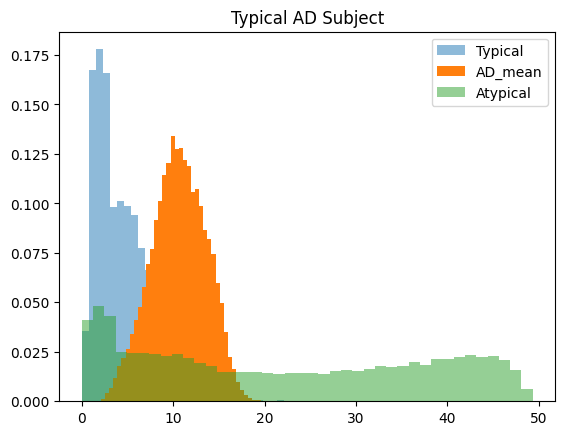

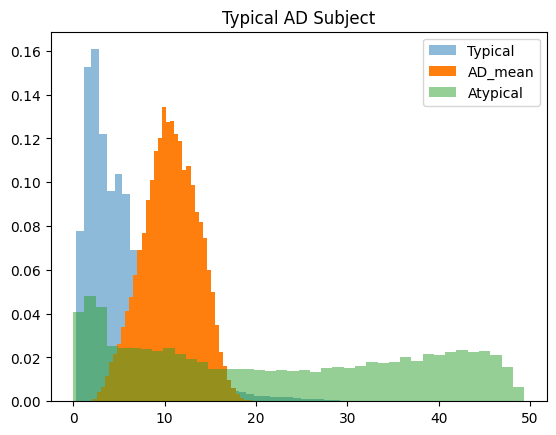

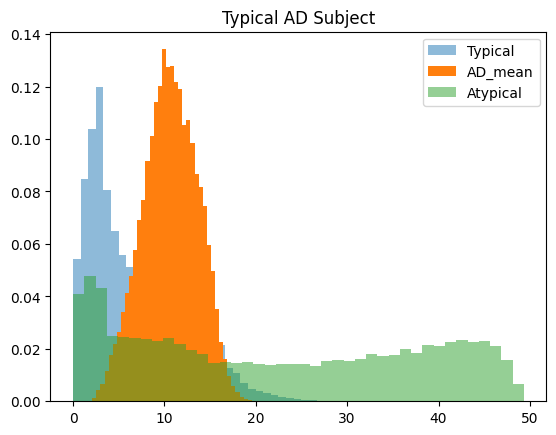

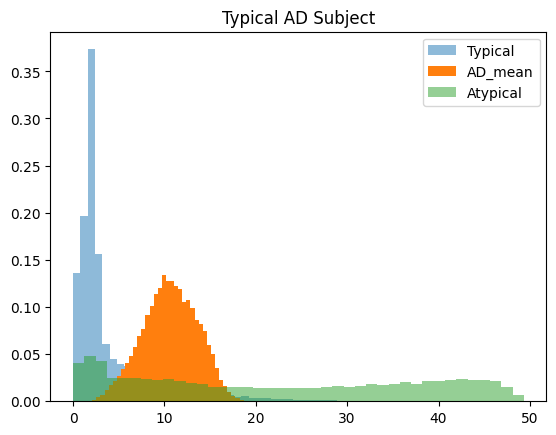

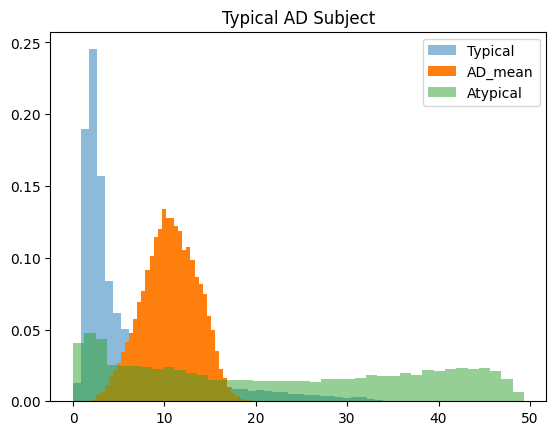

In [21]:
ad_taus_mean_w_outliers = np.nanmean(ad_taus, axis=0)
for i in ad_sub_idx:
    print(i)
    plt.hist(ad_taus[i], bins=40, density=True, alpha=0.5, label='Typical')
    plt.hist(ad_taus_mean_w_outliers, bins=40, density=True, label='AD_mean')

    del_taus_mean = np.nanmean(np.abs(ad_del_taus), axis=1)
    atyp = np.argsort(del_taus_mean)[-1]
    plt.hist(ad_taus[atyp], bins=40, density=True, alpha=0.5, label='Atypical')
    plt.title("Typical AD Subject")
    plt.legend()
    plt.show()

In [14]:
cn_sub_idx, cn_del_taus = find_group_typicals(cn_taus, alpha=2, sub_idx_map=cn_subs)
print(cn_sub_idx, cn_del_taus.shape)

[40] (55, 228939)


In [15]:
typical_subs_data = {
    "cn_sub_idx" : cn_sub_idx,
    "ad_sub_idx" : ad_sub_idx,
    "cn_del_taus" : cn_del_taus,
    "ad_del_taus" : ad_del_taus,
}
np.savez("/home/shivansh.seth/phase_diagram_analysis/results/typical_subjects.npz", **typical_subs_data)

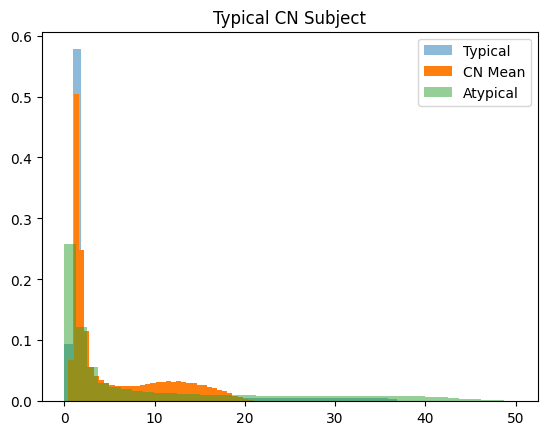

In [54]:
cn_taus_mean_w_outliers = np.nanmean(cn_taus, axis=0)
for i in sub_idx:
    plt.hist(cn_taus[i], bins=40, density=True, alpha=0.5, label='Typical')
    plt.hist(cn_taus_mean_w_outliers, bins=40, density=True, label='CN Mean')

    del_taus_mean = np.nanmean(np.abs(del_taus), axis=1)
    atyp = np.argsort(del_taus_mean)[-1]
    plt.hist(cn_taus[atyp], bins=40, density=True, alpha=0.5, label='Atypical')
    plt.title("Typical CN Subject")
    plt.legend()
    plt.show()

## Removing outlier taus

In [16]:
def get_accepted_ranges(rrts):
    accepted_ranges = []
    for roi_ind in range(rrts.shape[1]):
        q1, q3 = np.nanpercentile(rrts[:, roi_ind], [25, 75])

        # Calculate IQR
        iqr = q3 - q1

        # Calculate lower and upper bounds
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

        accepted_ranges.append((lower_bound, upper_bound))
    accepted_ranges = np.array(accepted_ranges)

    return accepted_ranges

In [17]:
def get_outliers(rrts, accepted_ranges, sub_idxs=None):
    outliers = []
    for i in range(rrts.shape[1]):
        rejected_subs = np.where( (rrts[:, i] < accepted_ranges[i][0]) | (rrts[:, i] > accepted_ranges[i][1]) )[0]
        nan_subs = np.where(np.isnan(rrts[:, i]))[0]
        outliers.append(list(set(list(rejected_subs) + list(nan_subs))))
    
    # Popping elements not included in subject list without 
    # disturbing original indices
    if not (type(sub_idxs) == type(None)):
        for roi_ind in range(len(outliers)):
            non_sub_idx_outliers = []
            outliers[roi_ind] = list(outliers[roi_ind])

            for i in range(len(outliers[roi_ind])):
                if outliers[roi_ind][i] not in sub_idxs:
                    non_sub_idx_outliers.append(i)
            for i in sorted(non_sub_idx_outliers, reverse=True):
                del outliers[roi_ind][i]

    return outliers

In [18]:
ad_sub_idxs = [ i for i in range(len(dloader.subjects_list)) if dloader.diag[i] == 1 ]
cn_sub_idxs = [ i for i in range(len(dloader.subjects_list)) if dloader.diag[i] == 0 ]
len(ad_sub_idxs), len(cn_sub_idxs)

(34, 55)

##  SR Calculation

### Getting mean taus

In [19]:
indices = np.random.permutation(len(cn_taus))
split_idx = int(len(cn_taus) * 0.5) # splitting the array in half
spl1 = cn_taus[indices[:split_idx]]
spl2 = cn_taus[indices[split_idx:]]
# spl1 = cn_taus
# spl2 = ad_taus

spl1_ar = get_accepted_ranges(spl1)
spl2_ar = get_accepted_ranges(spl2)
cn_ar = get_accepted_ranges(cn_taus)
ad_ar = get_accepted_ranges(ad_taus)

spl1_outliers = get_outliers(spl1, spl1_ar)
spl2_outliers = get_outliers(spl2, spl2_ar)
cn_outliers = get_outliers(cn_taus, cn_ar)
ad_outliers = get_outliers(ad_taus, ad_ar)
print(spl1.shape, spl2.shape)

/scratch/shivansh.seth/preproc/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,


(27, 228939) (28, 228939)


In [20]:
def do_t_test(spl1, spl2, spl1_outliers, spl2_outliers):
    t_stat, p_value = [], []
    spl1_roi_rts_mean, spl2_roi_rts_mean = [], []
    spl1_roi_rts_std, spl2_roi_rts_std = [], []
    roi_rts_mean, roi_rts_std = [], []
    for roi_ind in range(spl1.shape[1]):

        spl1_accepted_subs = list(set(range(len(spl1))).difference(spl1_outliers[roi_ind]))
        spl2_accepted_subs = list(set(range(len(spl2))).difference(spl2_outliers[roi_ind]))
    #     ad_accepted_subs = list(set(range(len(ad_taus))).difference(ad_outliers[roi_ind]))
    #     cn_accepted_subs = list(set(range(len(cn_taus))).difference(cn_outliers[roi_ind]))


        split1 = spl1[spl1_accepted_subs, roi_ind]
        split2 = spl2[spl2_accepted_subs, roi_ind]
    #     split1 = ad_taus[ad_accepted_subs, roi_ind]
    #     split2 = cn_taus[cn_accepted_subs, roi_ind]

        spl1_roi_rts_mean.append(np.mean(split1)), spl2_roi_rts_mean.append(np.mean(split2))
        spl1_roi_rts_std.append(np.std(split1)), spl2_roi_rts_std.append(np.std(split2))
        roi_rts_mean.append(np.mean(np.concatenate([split1, split2])))
        roi_rts_std.append(np.std(np.concatenate([split1, split2])))

        t, p = stats.ttest_ind(split1, split2)
        t_stat.append(t), p_value.append(p)

        if roi_ind%10000 == 0:
            print(roi_ind, end=" ")

    spl1_roi_rts_mean = np.array(spl1_roi_rts_mean)
    spl2_roi_rts_mean = np.array(spl2_roi_rts_mean)
    spl1_roi_rts_std = np.array(spl1_roi_rts_std)
    spl2_roi_rts_std = np.array(spl2_roi_rts_std)
    roi_rts_mean = np.array(roi_rts_mean)
    roi_rts_std = np.array(roi_rts_std)

    p_value = np.array(p_value)
    t_stat = np.array(t_stat)
    
    return (t_stat, p_value), (spl1_roi_rts_mean, spl2_roi_rts_mean), \
        (spl1_roi_rts_std, spl2_roi_rts_std), (roi_rts_mean, roi_rts_std)

In [55]:
p_results = do_t_test(cn_taus, ad_taus, cn_outliers, ad_outliers)

t_stat, p_value = p_results[0]
cn_roi_rts_mean, ad_roi_rts_mean = p_results[1]
cn_roi_rts_std, ad_roi_rts_std = p_results[2]
taus_mean, taus_std = p_results[3]

# Print the results
print("t-statistic: ",  t_stat)
print("p-value: ", p_value)
print()

0 10000 20000 30000 40000 50000 60000 70000 80000 90000 100000 110000 120000 130000 140000 150000 160000 170000 180000 190000 200000 210000 220000 t-statistic:  [nan nan nan ... nan nan nan]
p-value:  [nan nan nan ... nan nan nan]



In [56]:
# t-test for CN-CN split

p_results = do_t_test(spl1, spl2, spl1_outliers, spl2_outliers)

t_stat, p_value = p_results[0]
spl1_roi_rts_mean, spl2_roi_rts_mean = p_results[1]
spl1_roi_rts_std, spl2_roi_rts_std = p_results[2]
taus_mean, taus_std = p_results[3]

# Print the results
print("t-statistic: ",  t_stat)
print("p-value: ", p_value)
print()

0 10000 20000 30000 40000 50000 60000 70000 80000 90000 100000 110000 120000 130000 140000 150000 160000 170000 180000 190000 200000 210000 220000 t-statistic:  [nan nan nan ... nan nan nan]
p-value:  [nan nan nan ... nan nan nan]



### Getting significant regions (based on mean difference)

In [67]:
sigma_mult = 1.3

sr = np.where( ( np.abs(cn_roi_rts_mean - ad_roi_rts_mean) > sigma_mult * np.abs(cn_roi_rts_std)))[0]
print("AD-CN split: Significant regions based on mean diff: \n", len(sr))

np.save("/home/shivansh.seth/phase_diagram_analysis/results/significant_regions_ss.npy", sr)

AD-CN split: Significant regions based on mean diff: 
 222


In [66]:
sr = np.where( ( np.abs(spl1_roi_rts_mean - spl2_roi_rts_mean) > sigma_mult * np.abs(taus_std)))[0]
print("CN-CN split: Significant regions based on mean diff: \n", len(sr))


CN-CN split: Significant regions based on mean diff: 
 0


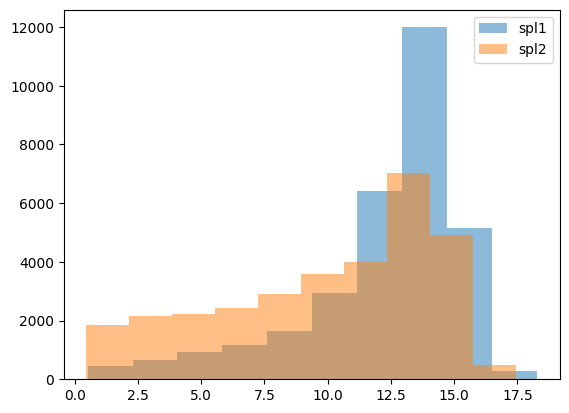

In [37]:
plt.hist(spl1_roi_rts_std, label='spl1', alpha=.5)
plt.hist(spl2_roi_rts_std, label='spl2', alpha=.5)
# plt.hist(rts_tau_std, label='overall', alpha=0.5)
plt.legend()

Text(0.5, 0.98, 'AD-CN Split')

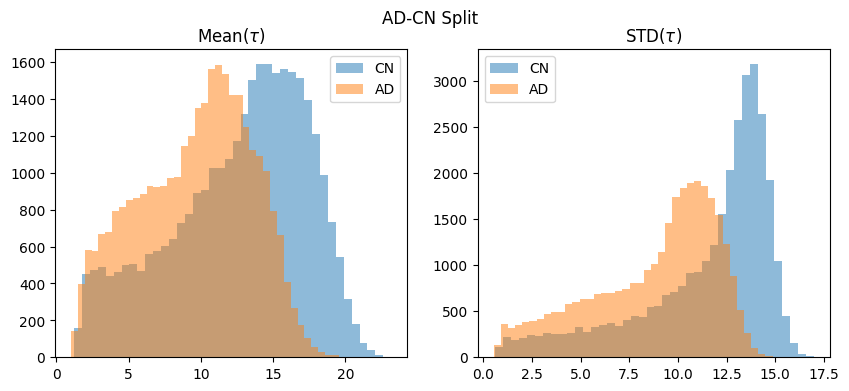

In [68]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 4))

axs[0].hist(cn_roi_rts_mean, label='CN', bins=40, alpha=.5)
axs[0].hist(ad_roi_rts_mean, label='AD', bins=40, alpha=.5)
axs[0].set_title("Mean($\\tau$)")
axs[0].legend()


axs[1].hist(cn_roi_rts_std, label='CN', bins=40, alpha=.5)
axs[1].hist(ad_roi_rts_std, label='AD', bins=40, alpha=.5)
axs[1].set_title("STD($\\tau$)")
axs[1].legend()

fig.suptitle("AD-CN Split")

Text(0.5, 0.98, 'CN-CN Split')

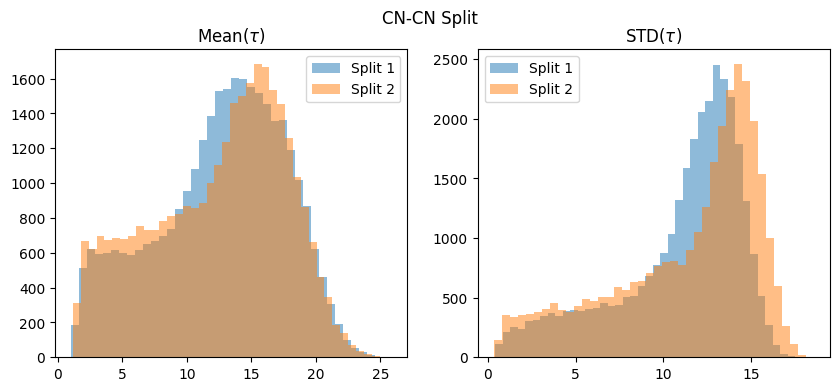

In [70]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 4))

axs[0].hist(spl1_roi_rts_mean, label='Split 1', bins=40, alpha=.5)
axs[0].hist(spl2_roi_rts_mean, label='Split 2', bins=40, alpha=.5)
axs[0].set_title("Mean($\\tau$)")
axs[0].legend()


axs[1].hist(spl1_roi_rts_std, label='Split 1', bins=40, alpha=.5)
axs[1].hist(spl2_roi_rts_std, label='Split 2', bins=40, alpha=.5)
axs[1].set_title("STD($\\tau$)")
axs[1].legend()

fig.suptitle("CN-CN Split")

In [32]:
len(np.where(~np.isnan(p_value))[0])

31569

In [39]:
sig_rois = list(np.where(p_value < 0.005)[0])
print("Significant RoIs:", len(sig_rois))

Significant RoIs: 3233


In [55]:
cn_taus_mean = spl1_roi_rts_mean
ad_taus_mean = spl2_roi_rts_mean
cn_taus_mean.shape, ad_taus_mean.shape

((228939,), (228939,))

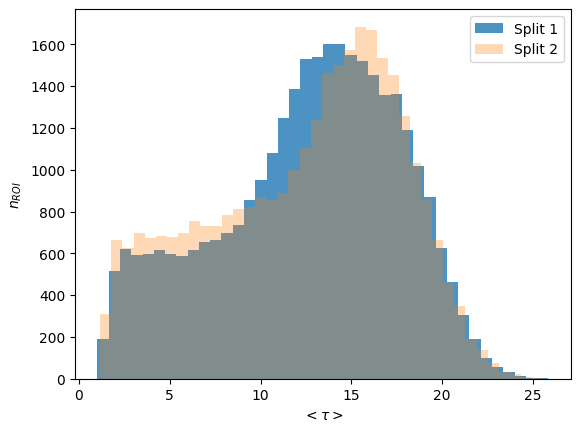

In [71]:
plt.hist(spl1_roi_rts_mean, label='Split 1', alpha=0.8, bins=40)
plt.hist(spl2_roi_rts_mean, label='Split 2', alpha=0.3, bins=40)
plt.legend()
plt.xlabel("$<\\tau>$")
plt.ylabel("$n_{ROI}$")
plt.show()

In [41]:
# plotting.plot_markers([1]*len(mni_coords.T), mni_coords.T)
intensity = 1/p_value[sig_rois]
intensity = (intensity - np.mean(intensity))/np.std(intensity)
plotting.plot_markers(intensity, mni_coords, node_threshold=0.5, node_cmap='gray')
# plotting.plot_markers(p_value[sig_rois, [[0,0,0]])

NameError: name 'mni_coords' is not defined

In [45]:
sr_fp = "/home/shivansh.seth/phase_diagram_analysis/results/significant_regions_ss.npy"
np.save(sr_fp, sig_rois)
print("Significant regions:")
print(len(sig_rois))

Significant regions:
3233


### Loading significant regions

In [42]:
sr_fp = "/home/shivansh.seth/phase_diagram_analysis/results/significant_regions_ss.npy"
sr = np.load(sr_fp)
print("Significant regions:")
print(sr)

FileNotFoundError: [Errno 2] No such file or directory: '/home/shivansh.seth/phase_diagram_analysis/results/significant_regions_ss.npy'

### Loading typical subjects

In [55]:
typical_subs_fp = "/home/shivansh.seth/phase_diagram_analysis/results/typical_subjects.npz"
with open(typical_subs_fp, 'rb') as f:
    typical_subs = np.load(f)
    ad_sub_idx = typical_subs['ad_sub_idx'][0]
    cn_sub_idx = typical_subs['cn_sub_idx'][0]
print("AD sub: ", ad_sub_idx, "; CN sub: ", cn_sub_idx)

AD sub:  20 ; CN sub:  40
